# 기본 라이브러리

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mat

In [2]:
import platform

if platform.system() == 'Darwin':
    mat.rc('font', family='AppleGothic')
    mat.rcParams['axes.unicode_minus'] = False

In [3]:
df = pd.read_csv("dataTotal.csv")
df['탑승일자'] = pd.to_datetime(df['탑승일자'])

# 필요 함수

## 함수(1) : 성분분해

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose

# 모든 변수에 대해 시계열 분해
def decompose_all_variables(df, columns, model_num, period):
    if model_num == 1: model = 'additive'
    elif model_num == 2: model = 'multiplicative'

    arr = []
    for col in columns:
        if col != '탑승일자':
            decomposed = seasonal_decompose(df[col], model=model, period=period)
            arr.append(decomposed)
    return arr

## 함수(2) : ACF 시각화

In [5]:
from statsmodels.tsa.stattools import acf

# ACF 계산 및 시각화 함수
def plot_acf(df, title, alpha=0.05, lags=40, threshold=0.2):
    variables = list(df.drop(labels='탑승일자', axis=1).columns)
    num_vars = len(variables)
    num_cols = 2
    num_rows = (num_vars + 1) // num_cols
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, num_rows * 3), sharex=True)
    fig.suptitle(title, fontsize=16)  # 전체 플롯 제목 설정
    axes = axes.flatten()  # 2D 배열을 1D로 변환
    
    for idx, var in enumerate(variables):
        data = df[var].dropna()
        acf_result = acf(data, alpha=alpha, nlags=lags)
        acf_values = acf_result[0]
        
        ax = axes[idx]
        ax.stem(range(len(acf_values)), acf_values, basefmt=" ", linefmt="blue", markerfmt="bo", label="ACF")
        ax.axhline(0, color="black", linestyle="--", linewidth=0.8, label="Zero Line")
        ax.axhline(threshold, color="red", linestyle="--", linewidth=1, label=f"Threshold (+{threshold})")
        ax.axhline(-threshold, color="green", linestyle="--", linewidth=1, label=f"Threshold (-{threshold})")
        ax.set_title(f"{var}의 ACF", fontsize=12)
        ax.set_xlabel("시차", fontsize=10)
        ax.set_ylabel("ACF", fontsize=10)
        ax.grid(True, linestyle="--", alpha=0.6)
        ax.legend(loc="upper right", fontsize=8)
    
    # 빈 서브플롯 제거
    for idx in range(len(variables), len(axes)):
        fig.delaxes(axes[idx])
    
    plt.subplots_adjust(hspace=0.4, wspace=0.4)
    plt.show()

## 함수(3) : PACF 시각화

In [6]:
from statsmodels.tsa.stattools import pacf
import matplotlib.pyplot as plt

# PACF 계산 및 시각화 함수
def plot_pacf(df, title, alpha=0.05, lags=40, threshold=0.2):
    variables = list(df.drop(labels='탑승일자', axis=1).columns)
    num_vars = len(variables)
    num_cols = 2
    num_rows = (num_vars + 1) // num_cols
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, num_rows * 3), sharex=True)
    fig.suptitle(title, fontsize=16)  # 전체 플롯 제목 설정
    axes = axes.flatten()  # 2D 배열을 1D로 변환
    
    for idx, var in enumerate(variables):
        data = df[var].dropna()
        pacf_result = pacf(data, alpha=alpha, nlags=lags, method='ols-adjusted')  # PACF 계산
        pacf_values = pacf_result[0]
        
        ax = axes[idx]
        ax.stem(range(len(pacf_values)), pacf_values, basefmt=" ", linefmt="blue", markerfmt="bo", label="PACF")
        ax.axhline(0, color="black", linestyle="--", linewidth=0.8, label="Zero Line")
        ax.axhline(threshold, color="red", linestyle="--", linewidth=1, label=f"Threshold (+{threshold})")
        ax.axhline(-threshold, color="green", linestyle="--", linewidth=1, label=f"Threshold (-{threshold})")
        ax.set_title(f"{var}의 PACF", fontsize=12)
        ax.set_xlabel("시차", fontsize=10)
        ax.set_ylabel("PACF", fontsize=10)
        ax.grid(True, linestyle="--", alpha=0.6)
        ax.legend(loc="upper right", fontsize=8)
    
    # 빈 서브플롯 제거
    for idx in range(len(variables), len(axes)):
        fig.delaxes(axes[idx])
    
    plt.subplots_adjust(hspace=0.4, wspace=0.4)
    plt.show()

## 함수(4) : 단위근 검정

In [17]:
from statsmodels.tsa.stattools import adfuller

def check_stationary(df, sig_level):
    cols = list(df.drop(labels='탑승일자', axis=1).columns)
    nonst_cnt = 0
    nonst_col = []

    for col in cols:
        result = adfuller(df[str(col)])
        print(f"<df[{col}]의 통계량과 p-value>")
        stat, pvalue = result[0], result[1]

        print(f"통계량 : {round(stat, 3)}, p-value : {round(pvalue, 3)}")
        if pvalue < sig_level:
            print(f"귀무가설 기각: df[{col}]은 정상성을 만족합니다.")
        else:
            nonst_cnt += 1
            nonst_col.append(col)
            print(f"귀무가설 채택: df[{col}]은 정상성을 만족하지 않습니다.")

    print(f"정상성 만족하지 않은 변수의 종류 : {nonst_col}")
    print(f"정상성 만족하지 않은 변수의 갯수 : {nonst_cnt}개")

# 모형 1 : ARIMA

* $Z_t$ 에 해당하는 변수들을 고르고, 해당 변수들을 시각화 및 검정해서 차수 p, q, d를 정한다.

* 이후 ARIMA 모형에 적합시킨다.

In [8]:
# Z_t가 담길 데이터프레임을 df1으로 설정
df1 = df[['탑승일자', '1호선', '4호선', '공항철도', '경의선']]

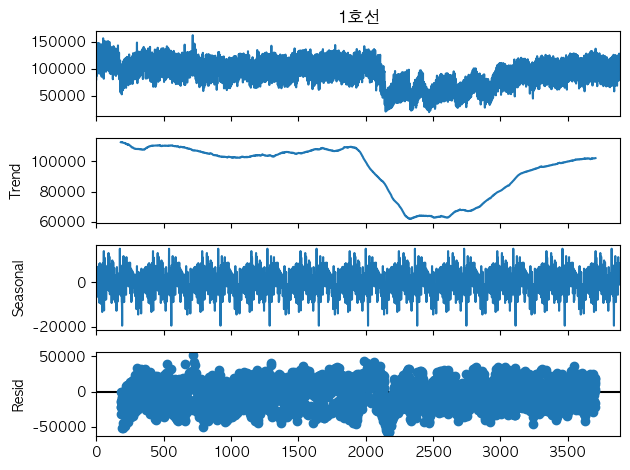

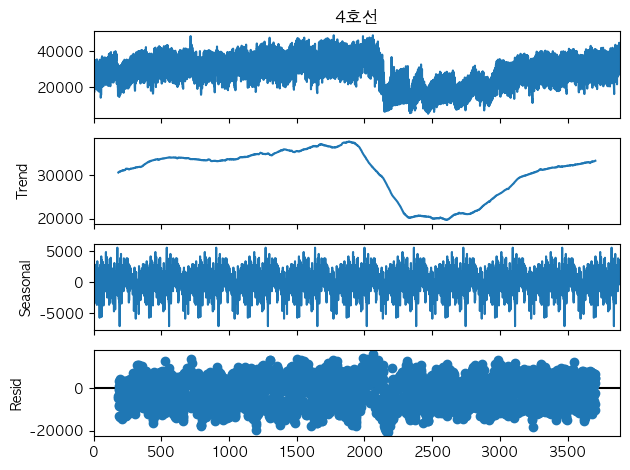

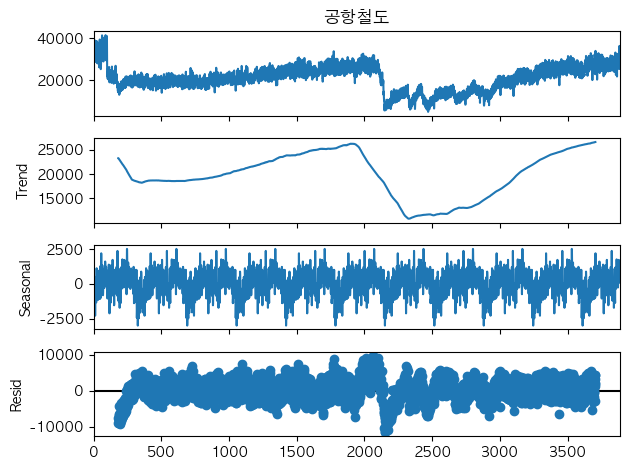

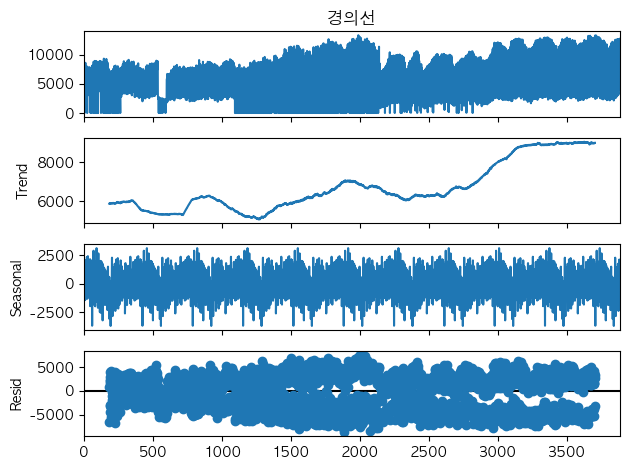

In [9]:
# 성분분해를 통해서 차분 I(d)의 차수 결정
# 변수 리스트
results = decompose_all_variables(df, df1.columns, 1, 365)      # 주기를 365로 해야 계절성을 파악할 수 있다.
for idx, result in enumerate(results):
    result.plot()
plt.show()

In [20]:
check_stationary(df1, 0.01)

<df[1호선]의 통계량과 p-value>
통계량 : -2.827, p-value : 0.055
귀무가설 채택: df[1호선]은 정상성을 만족하지 않습니다.
<df[4호선]의 통계량과 p-value>
통계량 : -2.904, p-value : 0.045
귀무가설 채택: df[4호선]은 정상성을 만족하지 않습니다.
<df[공항철도]의 통계량과 p-value>
통계량 : -2.635, p-value : 0.086
귀무가설 채택: df[공항철도]은 정상성을 만족하지 않습니다.
<df[경의선]의 통계량과 p-value>
통계량 : -3.981, p-value : 0.002
귀무가설 기각: df[경의선]은 정상성을 만족합니다.
정상성 만족하지 않은 변수의 종류 : ['1호선', '4호선', '공항철도']
정상성 만족하지 않은 변수의 갯수 : 3개


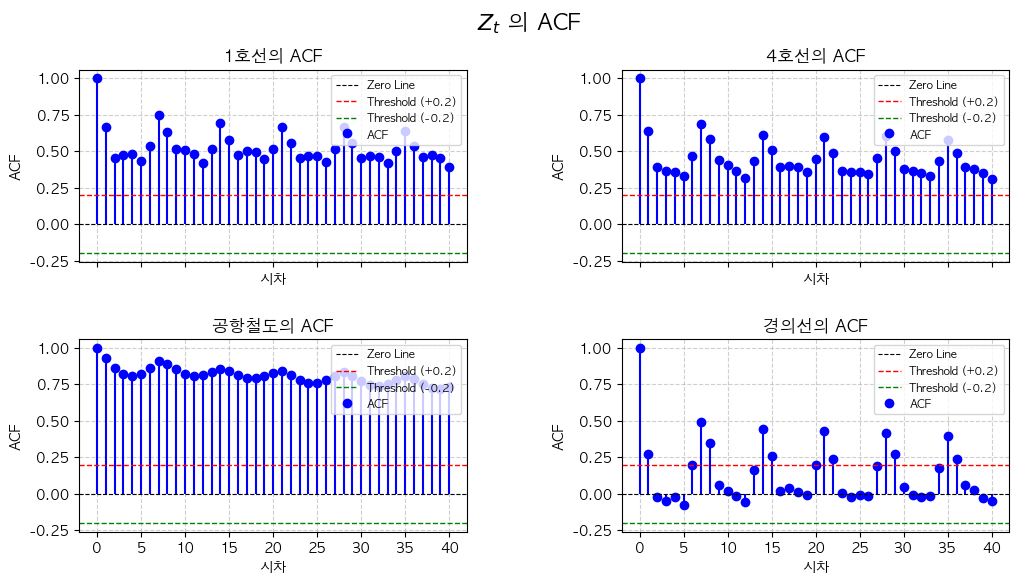

In [11]:
# ACF를 통해서 AR(p)에 해당하는 부분 결정
plot_acf(df1, r"$Z_t~$의 ACF")

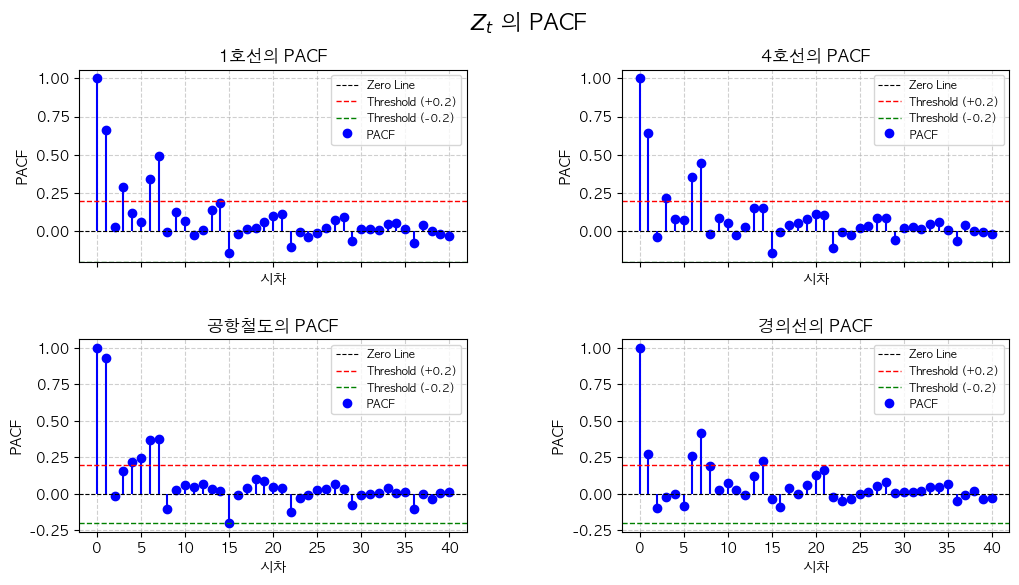

In [12]:
# PACF를 통해서 MA(q)에 해당하는 부분 결정
plot_pacf(df1, r"$Z_t~$의 PACF")

## 모형 적합

In [13]:
# train / test 분리
df1_train = df1[(df1['탑승일자'] >= '2015-01-01') & (df1['탑승일자'] <= '2022-12-31')]
print(df1_train.tail(), end='\n\n')

df1_test = df1[df1['탑승일자'] >= '2022-12-31']
print(df1_test.tail())

           탑승일자       1호선      4호선     공항철도      경의선
3213 2022-12-27  101954.0  33889.0  21252.0  10293.0
3214 2022-12-28  103652.0  34094.0  21230.0  10519.0
3215 2022-12-29  104708.0  33734.0  22070.0  10086.0
3216 2022-12-30  109068.0  32556.0  24514.0   9744.0
3217 2022-12-31   76430.0  21736.0  19405.0   2525.0

           탑승일자       1호선      4호선     공항철도      경의선
3883 2024-10-27  124598.0  41763.0  36351.0   5769.0
3884 2024-10-28  111814.0  39012.0  28125.0  12584.0
3885 2024-10-29  109220.0  39536.0  25445.0  12691.0
3886 2024-10-30  110730.0  39683.0  26052.0  12548.0
3887 2024-10-31  113842.0  39746.0  27893.0  12762.0


In [14]:
# train을 적합

from statsmodels.tsa.arima.model import ARIMA

# 모델 생성 및 학습
for 
    model = ARIMA(df[''], order=(p, d, q))  # p, d, q 값을 설정해야 합니다.
    fitted_model = model.fit()

# 결과 출력
print(fitted_model.summary())

SyntaxError: invalid syntax (1033590904.py, line 6)

In [ ]:
# test로 평가
df1_test['1호선']

# 모형 2 : SARIMAX

* $Z_t$ 에 해당하는 변수들을 고르고, 해당 변수들을 시각화 및 검정해서 차수 p, q, d를 정한다.

* $X_t$ 에 해당하는 변수들을 고르고, 해당 변수들을 시각화 및 검정해서 차수 p, q, d를 정한다.

* 이후 ARIMA 모형에 적합시킨다.